# Inbalanced Classes
## In this lab, we are going to explore a case of imbalanced classes. 


Like we disussed in class, when we have noisy data, if we are not careful, we can end up fitting our model to the noise in the data and not the 'signal'-- the factors that actually determine the outcome. This is called overfitting, and results in good results in training, and in bad results when the model is applied to real data. Similarly, we could have a model that is too simplistic to accurately model the signal. This produces a model that doesnt work well (ever). 


In [1]:
import pandas as pd
import numpy as np

#Visualización
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (16,6)

#Umbalanced
from imblearn.under_sampling import NearMiss, RandomUnderSampler

#Statsmodels
import statsmodels.api as sm

#Sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss
from sklearn.metrics import auc, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve

from sklearn.linear_model import LogisticRegression

from sklearn.neighbors import KNeighborsClassifier

from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier

from sklearn.neural_network import MLPClassifier

Using TensorFlow backend.
/Users/MarLizana/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/MarLizana/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/MarLizana/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/MarLizana/opt/anaconda3/l

In [2]:
def heatmap_ml (df):
    
    """
    
    ****************************************************************************
    Valores predefinidos para el heatmap:
    - Colores divergentes
    - Etiquetas de valor
    - Solo la mitad
    
    Input:
    - DataFrame
    
    Output:
    -Heatmap
    
    ****************************************************************************
    
    """
    
    corr = df.corr().round(2)
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True

    with sns.axes_style("white"):
        f, ax = plt.subplots(figsize=(16, 8))

        ax = sns.heatmap(corr, cmap = 'RdBu_r', annot=True,  mask=mask, vmax=1, vmin= -1, square=True)

In [3]:
def drop_corr (df, col):
    
    """
    
    !!! USA OTRA FUNCIÓN !!!
    
    ****************************************************************************
    
    Eliminación hacia atrás con heatmap.Borra la columna que indiques y vuelve a pintar el heatmap.
    
    Input:
    - df: Nombre del dataframe
    - col: Nombre de la columna a borrar
    
    Output:
    - DataFrame sin la columna eliminada
    - Heatmap con las nuevas correlaciones
    
    ****************************************************************************
    
    """
    
    df.drop(col, inplace=True, axis=1)
    heatmap_ml(df)

In [4]:
def describe_df (df):
    
    """
    
    !!! USA OTRA FUNCIÓN !!!
    
    ****************************************************************************
    
    Muestra información básica del dataframe que le pases.
    
    Input:
    -DataFrame
    
    Output:
    - Número de filas y columnas
    - DataFrame con:
        * 'type': Tipos de columnas
        * 'nan': Número de valores nulos
        * 'nan_ratio_col': Ratio de valores nulos en la columna
        * 'nan_ratio_total': Ratio de valores nulos en el total del dataset
        * 'unique_values': Número de valores únicos que tiene esa columna
        * 'mean': media de las columnas numéricas
        * 'std': desviación estándard de las columnas numéricas
        * 'min': mínimo de las columnas numéricas
        * '25%': primer cuartil de las columnas numéricas
        * '50%': segundo cuartil de las columnas numéricas
        * '75%': tercer cuartil de las columnas numéricas
        * 'max': máximo de las columnas numéricas
        
    - Heatmap de correlación
    
    ****************************************************************************
    
    """
    
    print(f'Hay un total de {df.shape[0]} filas y {df.shape[1]} columnas.')
    
    print (heatmap_ml(df))
    
    describe_df = pd.DataFrame(df.dtypes, columns = ["type"])
    describe_df["nan"] = df.isna().sum()
    describe_df["nan_ratio_col"] = [round(df.isna().sum()[col]/len(df[col])*100, 2) for col in df.columns]
    describe_df["nan_ratio_total"] = [round(df.isna().sum()[col]/df.shape[0]*100, 2) for col in df.columns]
    describe_df['unique_values'] = [len(pd.unique(df[col])) for col in df.columns]
    describe_df = describe_df.join(df.describe().T[['mean', 'std', 'min', '25%', '50%', '75%', 'max']], on = describe_df.index)
    
    return describe_df

In [5]:
def cat_column_analysis (df, col, y):
    
    """
    
    ****************************************************************************
    
    Dada un columna devuelve información relacionada con nulos y distribución.
    
    Inputs:
    df. datafrme
    col. nombre de la columna
    y. variable dependiente
    
    Output:
    -Valores nulos y su ratio si hay.
    -% de cada valor
    -bar plot
    
    ****************************************************************************
    
    """
    
    df_temp = pd.DataFrame(df[col])
    
    #Valores nulos
    if df[col].isnull().sum()>0:  
        print(f"Valores nulos: {df[col].isnull().sum()}. Un {round((df[col].isnull().sum()/len(df[col])*100),2)}%")
        df_temp[col] = df[col].fillna("NaN")
    else:
        print("No hay valores nulos.")
        
    # % según los valores únicos    
    print("Ratio de valores:")
    cd = pd.DataFrame(df_temp[col].value_counts())
    cd["%"] = [round((cd[col][value]/cd[col].sum()),4)*100 for value in cd.index]
    print(cd)
    
    #Visualización de la distribución
    print("Distribución:")
    display(df_temp[col].hist())
    plt.show()
    
    print('\n')
    
    #mostrar el impacto de las distintos valores de la variable en el target (No-show)
    df_temp2 = pd.DataFrame(df[[col, y]])

    print(f"Impacto de {col} en {y}")

    df_temp2 = df_temp2.groupby([col, y ]).agg({col:'count'})
    df_temp2['%'] = [round((df_temp2[col][value]/df_temp2[col][df_temp2.index.get_level_values(0)==value[0]].sum())*100,2)
    for value in df_temp2.index]
    print(df_temp2)

In [6]:
def under_sampling_nr (df, col_dep):
    
    """
    Devuelve el df reducido con NearMiss
    Input:
    *df
    *col_dep: variable dependiente
    
    """
    
    X = df.drop(col_dep, axis = 1)
    y = df[col_dep]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
    
    nr = NearMiss()
    X_res, y_res = nr.fit_sample(X_train, y_train)
    
    df_temp = pd.DataFrame(X_res, columns = df.columns[:-1])
    df_temp[col_dep] = y_res
    
    return df_temp

In [7]:
def rand_under_sampling (df, col_dep):
    
    """
    Devuelve el df reducido con RandomUnderSample
    Input:
    *df
    *col_dep: variable dependiente
    
    """
    
    X = df.drop(col_dep, axis = 1)
    y = df[col_dep]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
    
    rus = RandomUnderSampler()
    X_res, y_res = rus.fit_sample(X_train, y_train)
    
    df_temp = pd.DataFrame(X_res, columns = df.columns[:-1])
    df_temp[col_dep] = y_res
    
    return df_temp

### First, download the data from: https://www.kaggle.com/ntnu-testimon/paysim1. Import the dataset and provide some discriptive statistics and plots. What do you think will be the important features in determining the outcome?

In [8]:
# Your code here
data= pd.read_csv("PS_20174392719_1491204439457_log.csv")

In [9]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


Hay un total de 6362620 filas y 11 columnas.
None


,type,nan,nan_ratio_col,nan_ratio_total,unique_values,mean,std,min,25%,50%,75%,max
step,int64,0,0.0,0.0,743,2.433972e+02,1.423320e+02,1.0,156.00,239.000,3.350000e+02,7.430000e+02
type,object,0,0.0,0.0,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
amount,float64,0,0.0,0.0,5316900,1.798619e+05,6.038582e+05,0.0,13389.57,74871.940,2.087215e+05,9.244552e+07
nameOrig,object,0,0.0,0.0,6353307,NaN,NaN,NaN,NaN,NaN,NaN,NaN
oldbalanceOrg,float64,0,0.0,0.0,1845844,8.338831e+05,2.888243e+06,0.0,0.00,14208.000,1.073152e+05,5.958504e+07
newbalanceOrig,float64,0,0.0,0.0,2682586,8.551137e+05,2.924049e+06,0.0,0.00,0.000,1.442584e+05,4.958504e+07
nameDest,object,0,0.0,0.0,2722362,NaN,NaN,NaN,NaN,NaN,NaN,NaN
oldbalanceDest,float64,0,0.0,0.0,3614697,1.100702e+06,3.399180e+06,0.0,0.00,132705.665,9.430367e+05,3.560159e+08
newbalanceDest,float64,0,0.0,0.0,3555499,1.224996e+06,3.674129e+06,0.0,0.00,214661.440,1.111909e+06,3.561793e+08
isFraud,int64,0,0.0,0.0,2,1.290820e-03,3.590480e-02,0.0,0.00,0.000,0.000000e+00,1.000000e+00


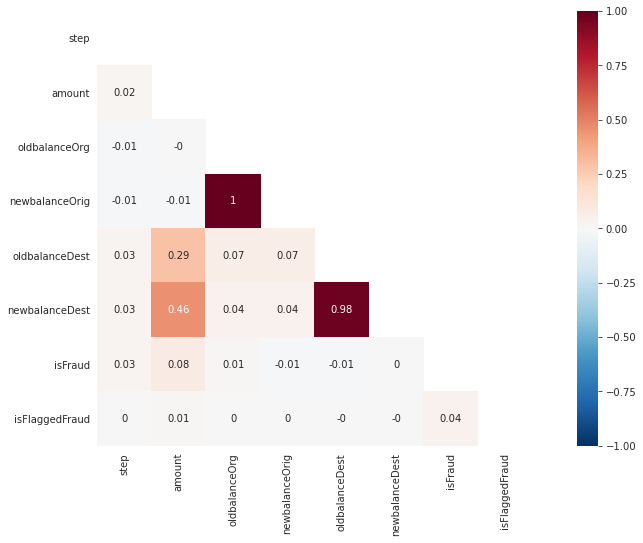

In [10]:
describe_df (data)

No hay valores nulos.
Ratio de valores:
             type      %
CASH_OUT  2237500  35.17
PAYMENT   2151495  33.81
CASH_IN   1399284  21.99
TRANSFER   532909   8.38
DEBIT       41432   0.65
Distribución:


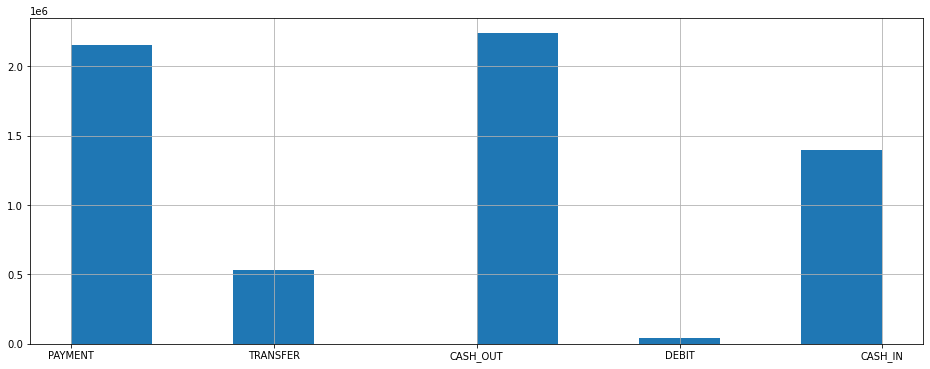



Impacto de type en isFraud
                     type       %
type     isFraud                 
CASH_IN  0        1399284  100.00
CASH_OUT 0        2233384   99.82
         1           4116    0.18
DEBIT    0          41432  100.00
PAYMENT  0        2151495  100.00
TRANSFER 0         528812   99.23
         1           4097    0.77


In [11]:
cat_column_analysis (data, "type", "isFraud")

In [ ]:
"""
Vemos que solo ocurre fraude en CASH_OUT y TRANSFER pero en un % muy pequeño, 0.18% y 0.77% respectivamente. 
En el resto de tipos de transacciones el % de fraude es 0. 

"""

### What is the distribution of the outcome? 

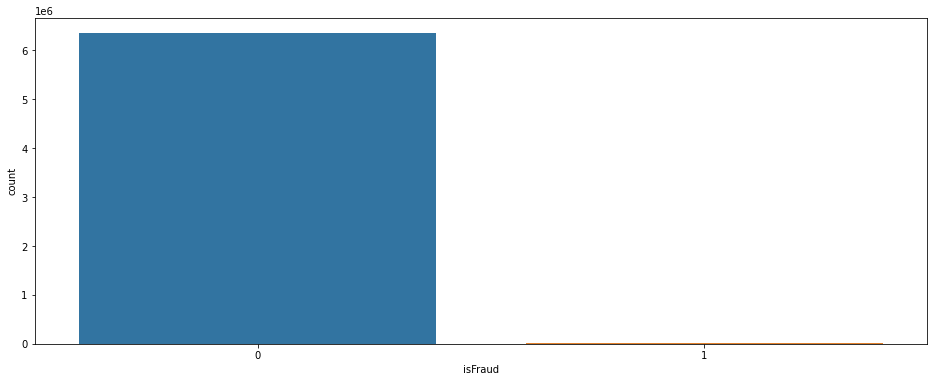

In [12]:
# Your response here
sns.countplot(data["isFraud"])

### Clean the dataset. How are you going to integrate the time variable? Do you think the step (integer) coding in which it is given is appropriate?

In [ ]:
# Your code here

""" 

Como hemos visto en la primera fase, hay muchos tipos de transacciones que no tienen fraude, los iliminaré.
Trambien las dos variables altamente correlacionadas.

"""

In [13]:
data_selection1 = data[data['type'].str.contains('CASH_OUT|TRANSFER')]

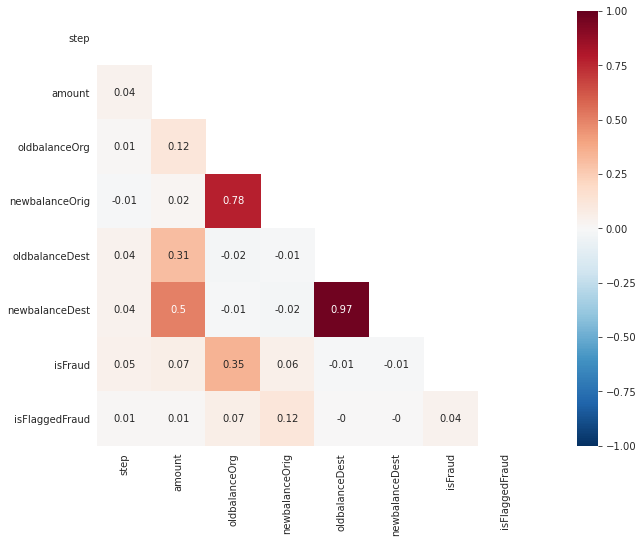

In [14]:
heatmap_ml (data_selection1)

/Users/MarLizana/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


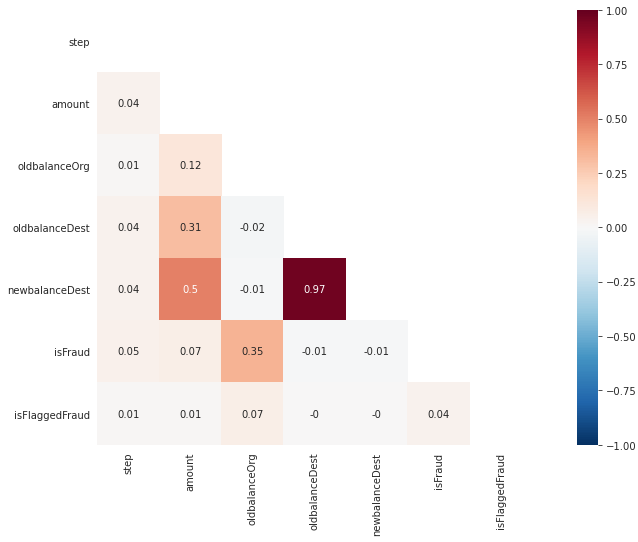

In [15]:
drop_corr (data_selection1, "newbalanceOrig")

/Users/MarLizana/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


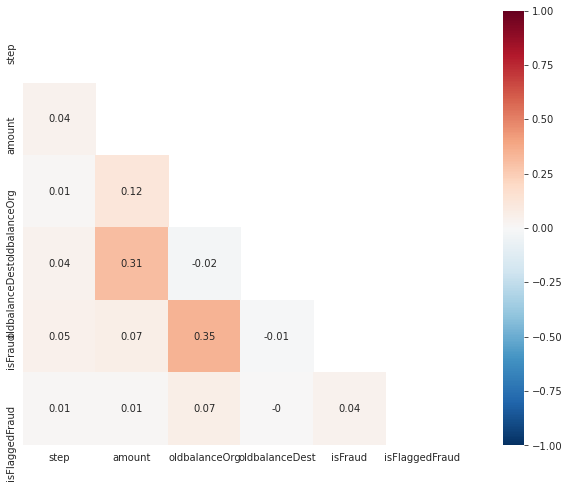

In [16]:
drop_corr (data_selection1, "newbalanceDest")

In [17]:
print(data_selection1.shape)
print(data_selection1["isFraud"].value_counts())

(2770409, 9)
0    2762196
1       8213
Name: isFraud, dtype: int64


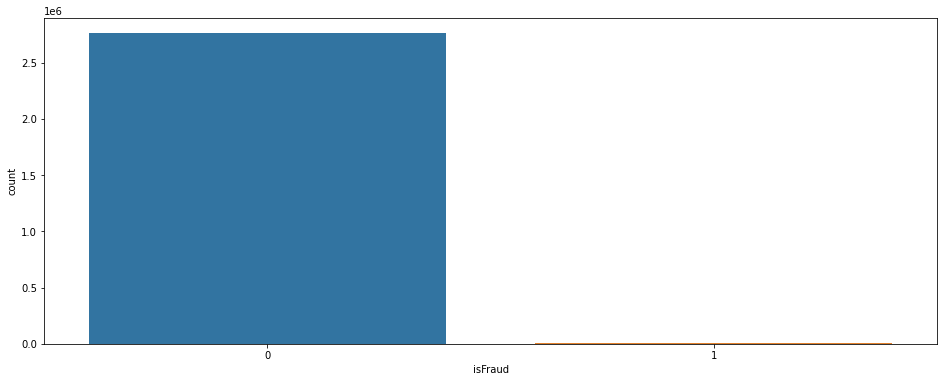

In [18]:
sns.countplot(data_selection1["isFraud"])

In [ ]:
"""
Siguen siendo mucho datos y terriblemente mal balanceados. Pasaremos a hacer un undersampling. Borro las columnas nameOrig
y nameDest.
"""

In [19]:
data_selection1.drop(['nameOrig', 'nameDest'], inplace=True, axis=1)

/Users/MarLizana/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [33]:
data_selection1 = pd.get_dummies(data_selection1, columns = ['type'])

KeyError: "None of [Index(['type'], dtype='object')] are in the [columns]"

In [34]:
data_selection1.dtypes

step                int64
amount            float64
oldbalanceOrg     float64
oldbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
type_CASH_OUT       uint8
type_TRANSFER       uint8
dtype: object

In [35]:
data_undersamp = under_sampling_nr (data_selection1, "isFraud")

Hay un total de 12320 filas y 7 columnas.
None


,type,nan,nan_ratio_col,nan_ratio_total,unique_values,mean,std,min,25%,50%,75%,max
step,int64,0,0.0,0.0,743,311.357711,1.931160e+02,1.0,165.0000,284.000,415.00,7.430000e+02
amount,float64,0,0.0,0.0,9870,754183.618640,1.836958e+06,0.0,20243.8875,79993.985,444898.97,1.000000e+07
oldbalanceOrg,float64,0,0.0,0.0,9382,842558.490004,2.602541e+06,0.0,20481.7500,79581.240,442722.01,5.958504e+07
oldbalanceDest,float64,0,0.0,0.0,2554,267876.748597,2.547574e+06,0.0,0.0000,0.000,0.00,2.362305e+08
isFraud,int64,0,0.0,0.0,2,0.500000,5.000203e-01,0.0,0.0000,0.500,1.00,1.000000e+00
isFlaggedFraud,int64,0,0.0,0.0,2,0.000974,3.119545e-02,0.0,0.0000,0.000,0.00,1.000000e+00
type_CASH_OUT,uint8,0,0.0,0.0,2,0.720536,4.487542e-01,0.0,0.0000,1.000,1.00,1.000000e+00


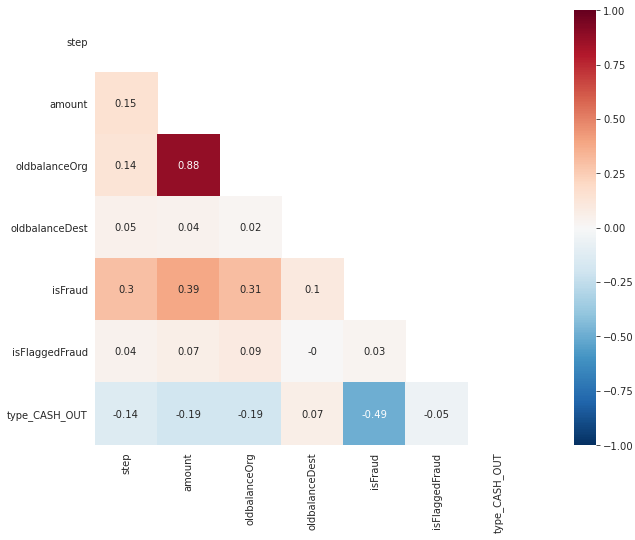

In [36]:
describe_df (data_undersamp)

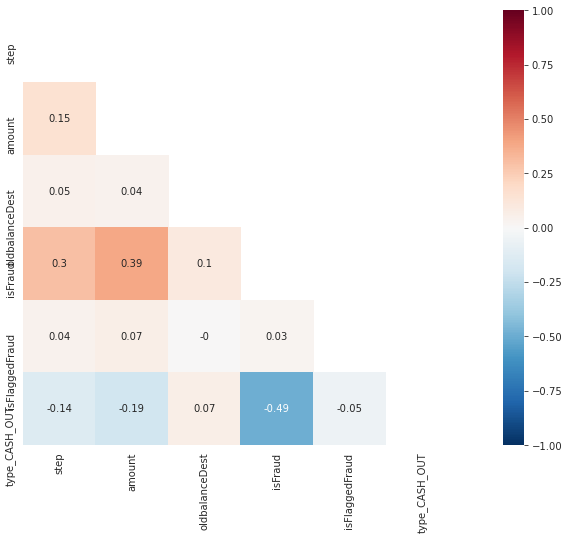

In [37]:
drop_corr (data_undersamp, "oldbalanceOrg")

In [38]:
print(data_undersamp.shape)
print(data_undersamp["isFraud"].value_counts())

(12320, 6)
1    6160
0    6160
Name: isFraud, dtype: int64


### Run a logisitc regression classifier and evaluate its accuracy.

In [39]:
# Your code here
X_train, X_test, y_train, y_test = train_test_split(data_undersamp.drop('isFraud', axis=1),
                                                    data_undersamp['isFraud'], random_state = 42, test_size=0.2)

In [40]:
logreg = LogisticRegression().fit(X_train, y_train)
print("Training set accuracy: {:.3f}".format(logreg.score(X_train, y_train)))
print("Test set accuracy: {:.3f}".format(logreg.score(X_test, y_test)))

Training set accuracy: 0.929
Test set accuracy: 0.932


In [41]:
y_pred = logreg.fit(X_train, y_train).predict(X_test)

In [42]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test,y_pred))

[[1204   47]
 [ 120 1093]]
              precision    recall  f1-score   support

           0       0.91      0.96      0.94      1251
           1       0.96      0.90      0.93      1213

    accuracy                           0.93      2464
   macro avg       0.93      0.93      0.93      2464
weighted avg       0.93      0.93      0.93      2464



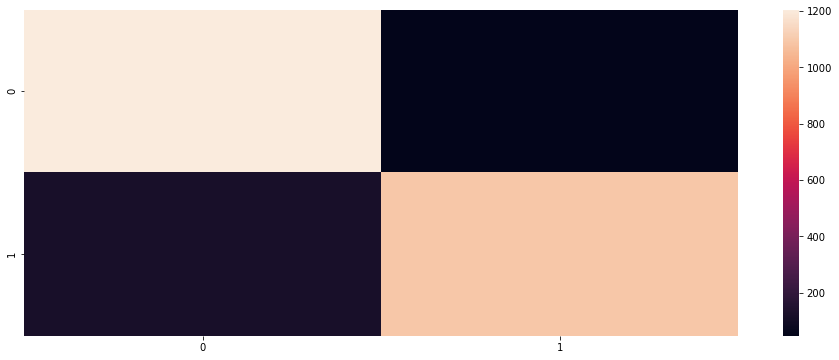

In [43]:
sns.heatmap(confusion_matrix(y_test, y_pred))

### Now pick a model of your choice and evaluate its accuracy.

In [44]:
# Your code here

KNN = KNeighborsClassifier(n_neighbors = 3).fit(X_train, y_train)

y_pred = KNN.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[1121  130]
 [ 187 1026]]
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1251
           1       0.89      0.85      0.87      1213

    accuracy                           0.87      2464
   macro avg       0.87      0.87      0.87      2464
weighted avg       0.87      0.87      0.87      2464



In [45]:
multi_layer_perceptron = MLPClassifier(hidden_layer_sizes=(400, ),random_state =42).fit(X_train, y_train)
y_pred = multi_layer_perceptron.predict(X_test)

print(confusion_matrix(y_test, y_pred))

print(classification_report(y_test, y_pred))

[[1205   46]
 [ 532  681]]
              precision    recall  f1-score   support

           0       0.69      0.96      0.81      1251
           1       0.94      0.56      0.70      1213

    accuracy                           0.77      2464
   macro avg       0.82      0.76      0.75      2464
weighted avg       0.81      0.77      0.76      2464



/Users/MarLizana/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


### Which model worked better and how do you know?

In [ ]:
# Your response here

"""
Parece que la regresión logística es la que mejores resultados está dando.
"""